### Reference:
https://ithelp.ithome.com.tw/articles/10223922
<br>
https://github.com/johngilbert2000/sentiment140_with_fastai/blob/master/TF_NLP_sentiment140.ipynb
<br>
https://blog.csdn.net/xc_zhou/article/details/88669669

In [1]:
import numpy as np
import pandas as pd
import datetime

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading Training Data from csv file

In [4]:
df = pd.read_csv("dataset/training.1600000.processed.noemoticon.csv", usecols=[0,5], header=None, names=['label','text'],encoding='latin-1')

In [5]:
df.tail(5)

,label,text
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
df.label.value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [7]:
# PREPARE DATA

# Randomize data
df = df.iloc[np.random.permutation(len(df))]

# For Classification: Convert Labels to negative = 0, neutral = 1, postive = 2 
df.loc[df['label'] == 4, 'label'] = 2

df.head()

,label,text
86317,0,Hola back from shopping what a complete waste...
418509,0,@scribblegurl Are you able to take any kind of...
127848,0,i didnt
74967,0,should rather do the maths assignment than the...
823240,2,@TrendTracker I will


In [8]:
# CREATE SUBSETS
splits = 5
# Equal length subsets of original dataframe
cut_indices = [int(i*(1/splits)*len(df)) for i in range(0,splits+1)] # indices where df is to be cut
segment_indices = zip(cut_indices[:-1], cut_indices[1:]) # indices for each cut segment
valids = [df[begin:end] for begin,end in segment_indices] # subsets each to be used as validation sets

# Training sets for each validation set in valids
trains = [pd.concat(valids[1:], axis=0)]
for n in range(1,splits):
    trains += [pd.concat(valids[:n]+valids[n+1:], axis=0)] # (all sets except for set n in range(splits))

# Validation and Training Sets to be used
validation = valids[0]
training = trains[0]

In [9]:
# a mean close to 0.5 for labels indicates a well balanced dataset
validation['label'].describe()['mean']

1.00285625

In [10]:
training.head()

,label,text
818283,2,Heading out to the mall and the park with my k...
622143,0,"You'd think I'd know by now, but leaving car w..."
1384971,2,@ThomasGudgeon Looks good
1243910,2,Writing loads of letters &gt;&gt; for autogra...
1380139,2,Goodnight tweets. 21 more days for my big brea...


In [11]:
# VECTORIZE DATASET

vocab_size = 10000 # 5000 # 10000

text = training['text'].to_numpy()

tok = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<unk>')

tok.fit_on_texts(text)

tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

# pad vectors to maxlength
train_text = training['text'].to_numpy()
train_seqs = tok.texts_to_sequences(train_text)
maxlength = max(len(i) for i in train_seqs)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=maxlength, padding='post')

print(maxlength)

118


In [12]:
train_labels = training['label'].to_numpy()
train_labels = to_categorical(train_labels, num_classes=3, dtype='uint8')

# pad vectors to maxlength (don't calculate automatically, or valid set will be of different size)
valid_text = validation['text'].to_numpy()
valid_seqs = tok.texts_to_sequences(valid_text)
valid_seqs = tf.keras.preprocessing.sequence.pad_sequences(valid_seqs, maxlen=maxlength, padding='post')

valid_labels = validation['label'].to_numpy()
valid_labels = to_categorical(valid_labels, num_classes=3, dtype='uint8')

# Use lowest possible types to speed up training
train_seqs = train_seqs.astype('uint16')
valid_seqs = valid_seqs.astype('uint16')

# Convert to TF dataset format
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_seqs,valid_labels))

In [13]:
import typing
import numbers
import os
import unittest
import random
import copy

In [14]:
# USEFUL FUNCTIONS

def word2vec(words):
    if isinstance(words, str):
        "Takes a string of words and returns a list of corresponding integers"
        seq = tok.texts_to_sequences([words])
        return np.array(seq).flatten().tolist()
    elif isinstance(words, typing.Iterable):
        "Takes a list of strings and returns a list of sequences (lists of corresponding integers)"
        return tok.texts_to_sequences(words)
    else:
        raise ValueError(f'Words were of type {type(words)} but should be either a string or list of strings')
        

def vec2word(vec:typing.Iterable[typing.Any]):
    if isinstance(vec[0], numbers.Number):
        "Takes a list of ints and returns a corresponding string"
        return " ".join([list(tok.word_index.keys())[i-1] for i in vec])
    elif isinstance(vec[0], typing.Iterable):
        "Takes an array of sequences (i.e., a 2d array) and returns an array of strings"
        return [vec2word(i) for i in vec]
    else:
        raise ValueError( f'Input list should contain either ints or lists of ints, not {type(vec[0])}')

def vec2word_no_pad(vec:typing.Iterable[typing.Any]):
    "Removes padding and converts vectors of ints to strings"
    if isinstance(vec[0], numbers.Number):
        "Takes a list of ints and returns a corresponding string"
        return " ".join([list(tok.word_index.keys())[i-1] for i in vec if i != 0])
    elif isinstance(vec[0], typing.Iterable):
        "Takes an array of sequences (i.e., a 2d array) and returns an array of strings"
        return [vec2word(i) for i in vec if i != 0]
    else:
        raise ValueError( f'Input list should contain either ints or lists of ints, not {type(vec[0])}')

def show_batch(ds):
    "Takes a tensorflow dataset and returns a batch as a dataframe, with labels shown without padding"
    batch_vecs, batch_targets = next(iter(ds.batch(1)))  # iterate through dataset batches
    batch_vecs, batch_targets = np.array(batch_vecs)[0], np.array(batch_targets)[0]  # convert tf batch to np array & reduce dimension by 1
    return pd.DataFrame(zip(batch_vecs, [vec2word_no_pad(arr) for arr in batch_vecs], batch_targets), columns=['word_vec','text','target'])

In [15]:
[32*i for i in range(1,10)] # Choose a multiple of 32 for embedding dimension

[32, 64, 96, 128, 160, 192, 224, 256, 288]

In [16]:
# TRAINING PARAMETERS

# Calculates the max_length, which can be used to store the attention weights
maxlength = max(len(i) for i in train_seqs)
total_vocab_size = len(tok.word_index) # no need to add +1, word_index includes <pad>
batch_size = 512 # 256 # 128 # 64
buffer_size = 1000 # 500 # 1000
embedding_dim = 64 # 32 # 64 # 128 # 256
num_steps = len(train_text) // batch_size
epochs = num_steps // buffer_size
val_steps = len(valid_seqs) // batch_size // epochs
learning_rate = 0.001 * 8

print(maxlength, vocab_size, total_vocab_size, num_steps, epochs, val_steps)

118 10000 595012 2500 2 312


In [17]:
# SHUFFLE AND BATCH

train_batch = train_ds.shuffle(buffer_size).batch(batch_size)
valid_batch = valid_ds.shuffle(buffer_size).batch(batch_size)
train_prefetch = train_batch.prefetch(buffer_size=tf.data.AUTOTUNE) # prefetch speeds up training
valid_prefetch = valid_batch.prefetch(buffer_size=tf.data.AUTOTUNE)

valid_batch

<BatchDataset shapes: ((None, 118), (None, 3)), types: (tf.uint16, tf.uint8)>

In [ ]:
# show_batch(valid_prefetch) # Note: determining <unk> words is a bottleneck

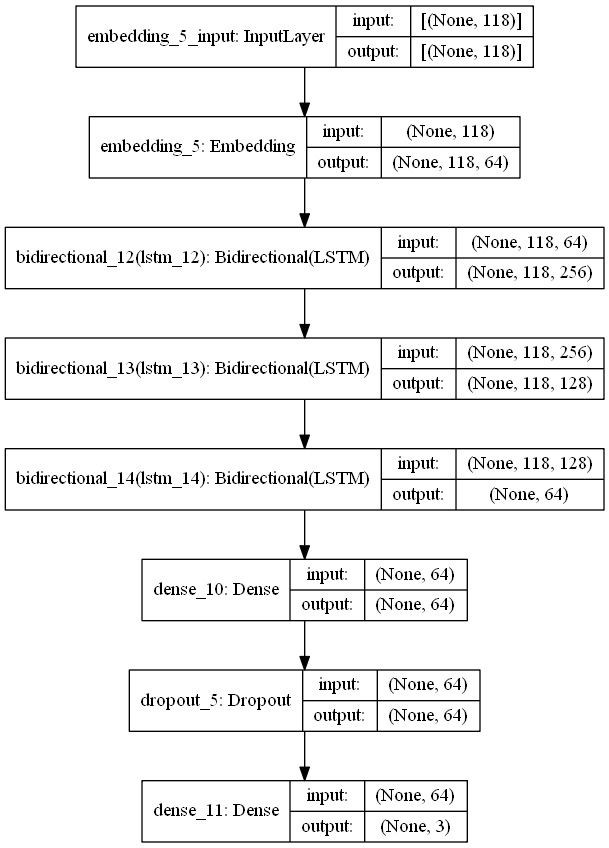

In [73]:
# Model 1
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlength),
    Bidirectional(LSTM(128,  return_sequences=True)),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

plot_model(model, to_file="image/base_model.png", show_shapes=True)

In [25]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # categorical_crossentropy for multilabel classification
              metrics=['accuracy'])

In [26]:
log_dir = "log/fit/" + datetime.datetime.now().strftime("Model_1-%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_prefetch,
    epochs=epochs,
    validation_data=valid_prefetch,
    validation_steps=val_steps,
    steps_per_epoch=buffer_size,
    callbacks=[tensorboard_callback]
    )

Epoch 1/2
1000/1000 [==============================] - 296s 289ms/step - loss: 0.4891 - accuracy: 0.7623 - val_loss: 0.4221 - val_accuracy: 0.8030
Epoch 2/2
1000/1000 [==============================] - 283s 283ms/step - loss: 0.4224 - accuracy: 0.8099 - val_loss: 0.4075 - val_accuracy: 0.8135


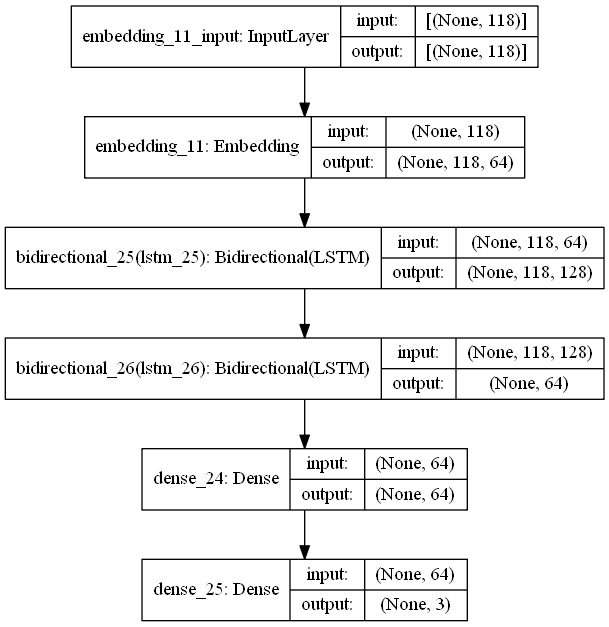

In [90]:
# Model 2
model_2 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlength),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(3, activation='sigmoid')
])

plot_model(model_2, to_file="image/improvement_model.png", show_shapes=True)

In [91]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy', # categorical_crossentropy for multilabel classification
              metrics=['accuracy'])

In [93]:
log_dir = "log/fit/" + datetime.datetime.now().strftime("Model_2-%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model_2.fit(
    train_prefetch,
    epochs=5,
    validation_data=valid_prefetch
    )

Epoch 1/5
2500/2500 [==============================] - 324s 129ms/step - loss: 0.3900 - accuracy: 0.8223 - val_loss: 0.3915 - val_accuracy: 0.8218
Epoch 2/5
2500/2500 [==============================] - 322s 129ms/step - loss: 0.3744 - accuracy: 0.8307 - val_loss: 0.3883 - val_accuracy: 0.8238
Epoch 3/5
2500/2500 [==============================] - 326s 130ms/step - loss: 0.3605 - accuracy: 0.8378 - val_loss: 0.3910 - val_accuracy: 0.8240
Epoch 4/5
2500/2500 [==============================] - 324s 129ms/step - loss: 0.3464 - accuracy: 0.8455 - val_loss: 0.4009 - val_accuracy: 0.8224
Epoch 5/5
2500/2500 [==============================] - 327s 131ms/step - loss: 0.3324 - accuracy: 0.8534 - val_loss: 0.4132 - val_accuracy: 0.8208


### Preparing Test Data

In [28]:
testdata_df = pd.read_csv("dataset/testdata.manual.2009.06.14.csv", usecols=[0,5], header=None, names=['label','text'],encoding='latin-1')

In [29]:
testdata_df.head(5)

,label,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [30]:
# For Classification: Convert Labels to negative = 0, neutral = 1, postive = 2 
testdata_df.loc[testdata_df['label'] == 2, 'label'] = 1
testdata_df.loc[testdata_df['label'] == 4, 'label'] = 2

In [33]:
testdata_df.tail(5)

,label,text
493,1,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,2,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."
497,0,Reading the tweets coming out of Iran... The w...


In [41]:
test_text = testdata_df['text'].to_numpy()
test_seqs = tok.texts_to_sequences(test_text)
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=maxlength, padding='post')

test_labels = testdata_df['label'].to_numpy()
test_labels = to_categorical(test_labels, num_classes=3, dtype='uint8')

In [44]:
model.evaluate(test_seqs, test_labels, callbacks=[tensorboard_evaluate_callback])

16/16 [==============================] - 0s 29ms/step - loss: 5.6346 - accuracy: 0.5904 0s - loss: 5.0855 - accuracy: 


[5.6346116065979, 0.5903614163398743]

In [94]:
model_2.evaluate(test_seqs, test_labels)

16/16 [==============================] - 1s 16ms/step - loss: 7.0459 - accuracy: 0.5904


[7.045896053314209, 0.5903614163398743]

In [51]:
pred_Y = model.predict(test_seqs)

# one-hot vector covert to class
pred_Y = np.argmax(pred_Y, axis=1)
true_Y = np.argmax(test_labels, axis=1)

In [54]:
# DRAW confusion-matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
conf_matrix = confusion_matrix(true_Y, pred_Y)

In [58]:
conf_matrix

array([[131,   0,  46],
       [ 20,   0, 119],
       [ 19,   0, 163]], dtype=int64)

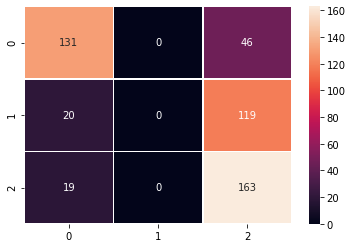

In [63]:
fig, ax = plt.subplots()         # Sample figsize in inches
fig = sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, ax=ax)

In [64]:
fig = fig.get_figure()
fig.savefig("image/confusion_matrix.png")